In [1]:
import librosa
import librosa.display
import numpy as np 
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wavio
import IPython.display

import utils
import plot

/Users/oharasoh/study/bandai/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/oharasoh/study/bandai/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
raw_specs, noised_specs = utils.load_spectrograms("../data")

In [3]:
raw_specs[2].shape

(128, 95)

In [8]:
input_dim = 128  # 128次元のメルスペクトログラム

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()


        self.conv1 = nn.Conv2d(1, 8, (5, 5), padding=(2, 2))
        self.act1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(8, 8, (3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        self.conv2_2 = nn.Conv2d(8, 8, (3,3), padding=1)
        self.act2_2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(8, 1, (3, 3), padding=1)
        
    def forward(self, x):
        """
        Input:
        x (torch.Tensor): (N, input_dim).
        Output:
        y (torch.Tensor): (N, output_dim).
        """
        x = self.conv1(x)
        x = self.act1(x)
        res = self.conv2(x)
        x = self.act2(res)
        x = self.conv2_2(x)
        x = self.act2_2(x)
        x += res
        x = self.conv3(x)
        return x
        

In [9]:
class SpecDataset(Dataset):
    def __init__(self, specs):
        self.specs = specs
            
    
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, idx):
        spec = self.specs[idx+1]
        spec = spec[np.newaxis, :, :]
        spec /= spec.max()
        return {"x": torch.Tensor(spec)}

In [15]:
model = Model()
train_dataset = SpecDataset(raw_specs)
test_dataset = SpecDataset(noised_specs)

In [16]:
spec = train_dataset[1]['x']
spec = spec.view(1, *spec.shape)
output = model(spec)

In [17]:
lr = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [27]:
epochs = 1001
name = "Conv2d_demo"
loss_record  = []
test_loss_record = []

for epoch in range(1000, epochs):
    train_idxs = np.arange(len(train_dataset))
    np.random.shuffle(train_idxs)
    test_idxs = np.arange(len(test_dataset))
    train_results = {}
    running_loss = 0.0
    for i, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs['x'])
        loss = criterion(outputs, inputs['x'])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_results[i + 1] = outputs.detach().cpu().numpy().reshape(*outputs.shape[2:])
        
    print('[%d] train loss: %.3e' % (epoch+1, running_loss/len(train_idxs)))
    loss_record.append(running_loss/len(train_idxs))
    running_loss = 0.0
    eval_results = {}
    for i, idx in enumerate(test_idxs):
        inputs = test_dataset[idx]
        with torch.no_grad():
            x = inputs['x'].view(1, *inputs['x'].shape)
            outputs = model(x)
            loss = criterion(outputs, x)
        running_loss += loss.item()
        scale = noised_specs[idx+1].max()
        eval_results[idx+1] = outputs.cpu().numpy().reshape(*outputs.shape[2:])
    print('[%d] test loss: %.3e' % (epoch+1, running_loss/len(test_idxs)))
    test_loss_record.append(running_loss/len(test_idxs))
    save_dir = f"../out/{name}/{epoch:02d}"
utils.save_specs(eval_results, save_dir=os.path.join(save_dir, "noised_tgt"))
utils.save_specs(train_results, save_dir=os.path.join(save_dir, "clean")) 

[1001] train loss: 6.003e-09
[1001] test loss: 3.937e-08


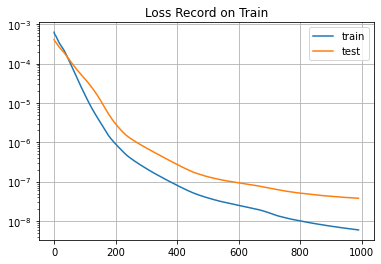

In [21]:
plt.title("Loss Record on Train")
plt.plot(np.convolve(loss_record, np.ones(10)/10.0, mode='valid'), label='train')
plt.plot(np.convolve(test_loss_record, np.ones(10)/10.0, mode='valid'), label='test')
plt.legend()
plt.yscale("log")
plt.grid()
plt.savefig("../fig/loss_record_conv2dAutoEncoder.png")

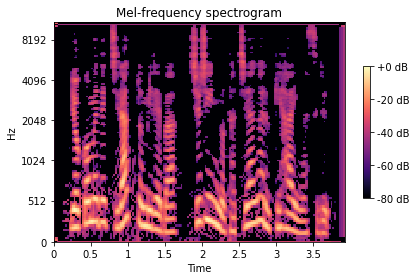

In [29]:
S0 = train_results[1]
plot.plot_spectrogram(S0, save_path="../fig/conv2d_results_train_data.png")

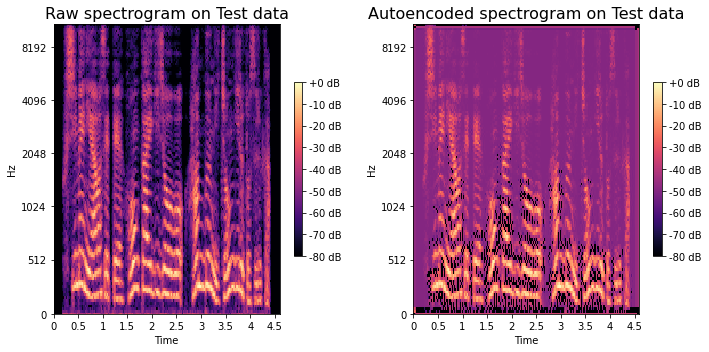

In [22]:
S0 = inputs['x'].detach().cpu().numpy().reshape(inputs['x'].shape[1:])
S1 = outputs.detach().cpu().numpy().reshape(outputs.shape[2:])
plot.plot_compared_spectrograms(
    S0, S1, title0="Raw spectrogram on Test data", title1="Autoencoded spectrogram on Test data",
    save_path="../fig/conv2d_ae_results.png"
    )

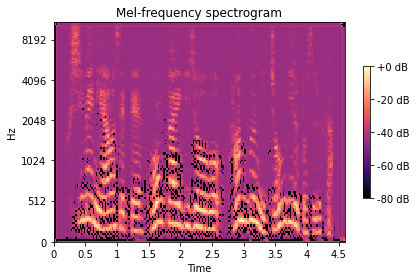

In [285]:
plot.plot_spectrogram(outputs.detach().cpu().numpy().reshape(outputs.shape[2:])*256)

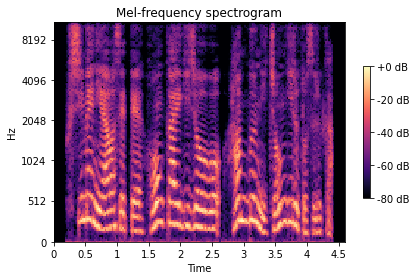

In [286]:
plot.plot_spectrogram(inputs['x'].detach().cpu().numpy().reshape(inputs['x'].shape[1:]))

In [30]:
wave = utils.reconstruct_audio(train_results[1])
utils.display_audio(wave, sr=22050)

In [23]:
wave = utils.reconstruct_audio(outputs.detach().cpu().numpy().reshape(outputs.shape[2:]))
utils.display_audio(wave, sr=22050)

In [24]:
wave = utils.reconstruct_audio(inputs['x'].detach().cpu().numpy().reshape(inputs['x'].shape[1:]))
utils.display_audio(wave, sr=22050)

In [285]:
max_ = 0
for idx in raw_specs:
    max_ = max(max_, raw_specs[idx].max())

In [286]:
max_

413.4232510032508

In [13]:
criterion(outputs, inputs['y']).item()

11.509880065917969

In [67]:
spec = torch.Tensor(spec.T)
new_spec = model(spec, train=False)

In [69]:
train_dataset = SpecDataset(raw_specs)

In [71]:
train_dataset[1]['spec'].shape

torch.Size([93, 384])